In [23]:
import torch
import librosa
import pandas as pd
import numpy as np
from parselmouth import Sound
from pathlib import Path

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

from tqdm.auto import tqdm
import xgboost as xgb

import pickle
import matplotlib.pyplot as plt

In [16]:
class paths:
  features_csv = '/vol/tensusers3/jdusseljee/2324-asr/myprosody_features/features.csv'

In [17]:
df = pd.read_csv(paths.features_csv)
df['gender'] = df['gender'].apply(lambda g: 0 if g == 'male' else 1)

df.head(2)

,Unnamed: 0,ID,age,gender,mmse,class,f1,f2,f3,f4,...,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
0,0,S001,74,0,NaN,0,207,32,2.30,3.8,...,88.9,0.6,132.13,41.61,120.2,76,381,115,128,0.80
1,1,S002,62,1,30.0,0,5,19,0.09,0.7,...,57.1,0.1,204.37,26.91,196.3,178,259,186,202,0.07


In [18]:
feature_cols = df.columns.to_list()[6:12] # + ['age', 'gender']
print(feature_cols)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6']


In [19]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
pred_df = pd.DataFrame()

for train, val in kfold.split(df):
  train_df = df.iloc[train]
  val_df = df.iloc[val].copy()

  X_train = train_df[feature_cols]
  y_train = train_df['class']
  X_val = val_df[feature_cols]
  y_val = val_df['class']

  model = xgb.XGBClassifier()
  model.fit(X_train, y_train)

  val_df.loc[:, 'pred'] = model.predict_proba(X_val)[:,1]

  pred_df = pd.concat([pred_df, val_df])

In [21]:
print(roc_auc_score(pred_df['class'], pred_df['pred']))
fpr, tpr, thresholds = roc_curve(pred_df['class'], pred_df['pred'])

0.6659807956104253


In [24]:
with open('fpr_svm.pickle', 'rb') as handle:
    fpr_svm = pickle.load(handle)
with open('tpr_svm.pickle', 'rb') as handle:
    tpr_svm = pickle.load(handle)

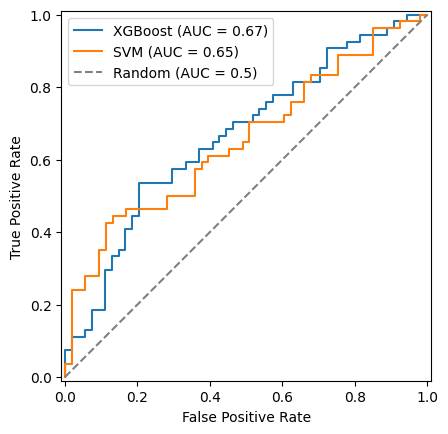

In [28]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(pred_df['class'], pred_df['pred']), estimator_name='XGBoost')
display.plot()

ax = plt.gca()

display_svm = RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm, roc_auc=0.65, estimator_name='SVM')
display_svm.plot(ax)

# Add AUC = 0.5 line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.5)')

# Show the plot with legend
plt.legend()
plt.show()